In [22]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import quimb as qi
import random
from time import time
from scipy.optimize import curve_fit
import pandas as pd

plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [23]:
def genOps(dims):
    """Generate array of operators sigmax, sigmay, sigmaz in numpy array form i th element of sigmaxs is sigmax on the i th site."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    sigmaxs = []
    sigmays = []
    sigmazs = []

    for i in range(n):
        sigmaxs.append(np.array(qi.ikron(qi.pauli('X'), dims, i)))
        sigmays.append(np.array(qi.ikron(qi.pauli('Y'), dims, i)))
        sigmazs.append(np.array(qi.ikron(qi.pauli('Z'), dims, i)))

    return sigmaxs, sigmays, sigmazs

def genAOps(dims):
    """Generate array of operators a, adag in numpy array form i th element of a is a on the i th mode."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    a = []
    adag = []

    for i in range(m):
        a.append(np.array(qi.ikron(qi.destroy(dims[n + i]), dims, n + i)))
        adag.append(np.array(qi.ikron(qi.create(dims[n + i]), dims, n + i)))

    return a, adag

def get_Lorentzian(wlist, nu_list, Gamma_list, kappa_list):
    fn = 0
    for i in range(len(nu_list)):
        nu = nu_list[i]
        Gamma = Gamma_list[i]
        fn += kappa_list[i]**2 * Gamma/2 * (1 / ((wlist - nu)**2 + (Gamma/2)**2) - 1 / ((wlist + nu)**2 + (Gamma/2)**2))   
    return fn

In [24]:
sim_time = 12.8 * 2*np.pi
steps = 128
tlist = np.linspace(0, sim_time, steps+1)

Nmax = 10
eps = 0.
Delta = 1.
# IMPORTNAT: nbar_list in increasing mode frequency order. w_list should thus be in decreasing order
nbar_list = np.array([0.1, 0.105])  
nu_list =  np.array([1.01, 0.99])
Gamma_list = np.array([0.01, 0.03]) 
kappa_list = np.array([1., 1.]) * 0.1

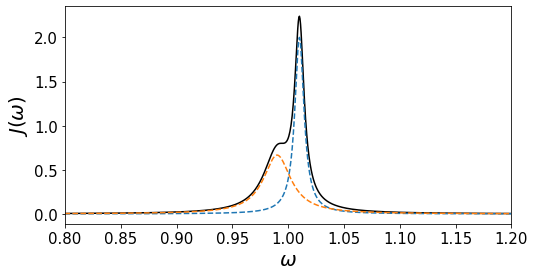

In [25]:
# target spectral density
color_list = ['tab:blue', 'tab:orange', 'tab:green']
wlist = np.linspace(0, 5, 10001)
sd_answer = get_Lorentzian(wlist, nu_list, Gamma_list, kappa_list)

fig, ax = plt.subplots(1, figsize=(8,4))
ax.plot(wlist[1600:2401], sd_answer[1600:2401], color='k')
for i in range(len(nu_list)):
    ax.plot(wlist, get_Lorentzian(wlist, [nu_list[i]], [Gamma_list[i]], [kappa_list[i]]), '--', color=color_list[i])
ax.set_xlim((0.8, 1.2))
ax.set_xlabel(r'$\omega$')
ax.set_ylabel(r'$J(\omega)$');
# ax.set_ylim((0,3))

In [26]:
dims = [2]
for i in range(len(nu_list)):
    dims += [Nmax]
sigmax, sigmay, sigmaz = genOps(dims)
a, adag = genAOps(dims)

H_mat = eps / 2 * sigmaz[0] + Delta / 2 * sigmax[0]
for i in range(len(nu_list)):
    H_mat = H_mat + nu_list[i] * adag[i] @ a[i]
    H_mat = H_mat + kappa_list[i]/2 * sigmaz[0] @ (a[i] + adag[i])
H = Qobj(H_mat, dims=[dims, dims])

init_state = ket2dm(basis(2,0))
for i in range(len(nbar_list)):
    init_state = tensor(init_state, thermal_dm(Nmax, nbar_list[i]))

e_ops_mat = [sigmaz[0]]
e_ops = [Qobj(e_op_mat, dims=[dims, dims]) for e_op_mat in e_ops_mat]

c_ops = []
for i in range(len(Gamma_list)):
    c_op_mat = np.sqrt(Gamma_list[i] * (nbar_list[i] + 1)) * a[i]
    c_ops += [Qobj(c_op_mat, dims=[dims, dims])]
    c_op_mat = np.sqrt(Gamma_list[i] * nbar_list[i]) * adag[i]
    c_ops += [Qobj(c_op_mat, dims=[dims, dims])]

# result = mesolve(H, init_state, tlist, e_ops=e_ops, c_ops=c_ops)
# simdata = np.array(result.expect[0] + 1)/2

In [27]:
simdata = np.load('2mode_fishbone.npy')[:steps+1]

In [29]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def analyze(data_list):
    expdata_all = np.array(data_list).reshape((len(data_list), -1))
    expdata = np.mean(expdata_all, axis=0)
    
    variance = np.std(expdata_all, axis=0)**2 / len(data_list)
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    
    return expdata, errorbar

data_list = []

for no in np.arange(1, 21).tolist():
    _, pop = readFile('Two_mode_%s'%str(no).zfill(3))
    data_list += [pop[:]]
expdata, errorbar = analyze(data_list)

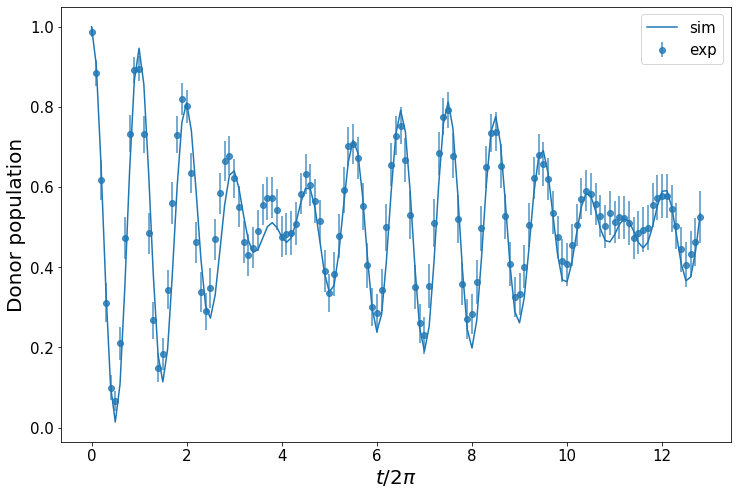

In [30]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(tlist/2/np.pi, simdata, '-', color='tab:blue', label='sim')
ax.errorbar(tlist/2/np.pi, expdata, yerr=errorbar, fmt='o', alpha=0.8, color='tab:blue', label='exp')
ax.set_xlabel(r'$t/2\pi$')
ax.set_ylabel('Donor population')
ax.legend();

In [31]:
with open('exp_data_2mode.npy', 'wb') as f:
    np.save(f, tlist)
    np.save(f, expdata)
    np.save(f, errorbar)